## Connect To Minetest

In [3]:
import miney
server="127.0.0.1"
playername="Minehart"
password=""
port=29999
mt = miney.Minetest(server, playername, password, port)
mt.chat.send_to_all("Hello World")

In [10]:
lua_lock_daytime = """
local timer = 0
minetest.register_globalstep(function(dtime)
	timer = timer + dtime;
	if timer >= 30 then
		minetest.set_timeofday(0.7)
		timer = 0
	end
end)
"""
lua_runner = miney.Lua(mt)
lua_runner.run(lua_lock_daytime)

## Load Data

In [1]:
import pickle
import numpy as np
import pandas as pd
with open('training_data.pkl','rb') as f:
    training_data = pickle.load(f)
    
with open('validation_data.pkl','rb') as f:
    validation_data = pickle.load(f)

### Most frequent segmentations

Each data point holds: [schematic, annotated_schematic, annotation_list, house_name]

Here we extract all segmentation matrices into a new list of numpy arrays.

In order to simplify the representations we combine semantically similar/equivalent segmentations (e.g. walls, wall).

We represent load-bearing structures and omit decorative elements from the structure.

In [3]:
annotation_data = training_data[0][2]
for i in range(1, len(training_data)):
    annotation_data = np.append(annotation_data, training_data[i][2])
for i in range(len(validation_data)):
    annotation_data = np.append(annotation_data, validation_data[i][2])

In [4]:
s = pd.Series(annotation_data)
ids = {}
id = 0
for val in list(s.unique()):
    ids[val] = id
    id += 1
    if id == 30:
        print(ids)

n = []
for v in s:
    n.append(ids[v])
    
ns = pd.Series(n)
vc = ns.value_counts()

seg = {v: k for k, v in ids.items()}
for v in vc.index:
    print(seg[v], v, vc[v])  

{'nothing': 0, 'roof': 1, 'windows': 2, 'wall': 3, 'door': 4, 'storage': 5, 'bed': 6, 'bookshelves': 7, 'none': 8, 'lights': 9, 'porch': 10, 'floor': 11, 'window': 12, 'pyramid top': 13, 'base': 14, 'layer': 15, 'bottom layer': 16, 'torch': 17, 'table': 18, 'foundation': 19, 'grass': 20, 'flower': 21, 'plant': 22, 'fence': 23, 'sign': 24, 'vines': 25, 'ground': 26, 'light': 27, 'purple block': 28, 'supports': 29}
wall 3 17087
window 12 10804
roof 1 5701
torch 17 5267
none 8 4203
floor 11 3185
lights 9 2973
door 4 2491
nothing 0 2050
stairs 30 1760
fence 23 1393
ground 26 1100
railing 31 973
grass 20 931
bed 6 861
light 27 824
flower 21 762
chest 40 695
foundation 19 655
ceiling 34 637
column 121 580
pillar 39 512
bush 229 499
decor 123 490
torches 105 489
ladder 71 479
support 88 460
windows 2 456
flowers 37 439
table 18 372
garden 43 337
lamp 167 283
steps 104 277
porch 10 254
dirt 161 254
pink cubes 173 237
stone 70 236
candle 49 231
walkway 36 229
bookcase 124 224
chests 62 210
book

the average house is made up of 59 segments

58.92673322693011 0 1037


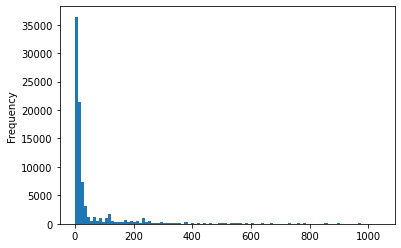

In [8]:
ns.plot.hist(bins=100)
print(ns.mean(), ns.min(), ns.max())

### Overview of block types and usage rates

5      240195
1       52300
251     45001
155     42211
126     40447
        ...  
147         6
115         4
28          4
218         2
149         2
Length: 218, dtype: int64

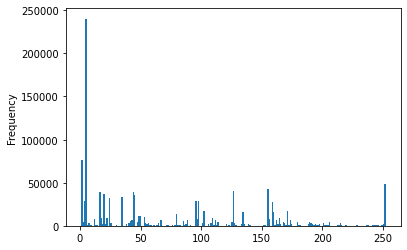

In [41]:
block_data = training_data[0][0]
for i in range(1, len(training_data)):
    block_data = np.append(block_data, training_data[i][0])
for i in range(len(validation_data)):
    block_data = np.append(block_data, validation_data[i][0])
    
s = pd.Series(block_data)
s = s[s!=0]
s.plot.hist(bins=251)

In [4]:
blocks = {}
key = -1
name = ""
lastname = ""
with open('MinecraftIDs.txt','rb') as f:
    for line in f.readlines():
        line = str(line)
        if line.find('\"id\"') != -1:
            id_end = line.find('</')
            key = line[23:id_end]
        if line.find('ft:') != -1:
            name_st = line.find('ft:') + 3
            name_nd = line.find(')</span></td>')
            name = line[name_st:name_nd]
        try:
            if int(key) in ids and name != lastname:
                blocks[int(key)] = name
                lastname = name
                if int(key) >= max:
                    break
        except:
            continue
blocks

{}

In [4]:
houses = []
for i in range(len(training_data)):
    houses.append(training_data[i][0])
for i in range(len(validation_data)):
    houses.append(validation_data[i][0])

every house fits in a 32x32x32 matrice

In [44]:
with open('structures.pkl','rb') as f:
    structures = pickle.load(f)
    
(maxX, maxY, maxZ) = (0, 0, 0)
for house in structures:
    maxX = maxX if (house.shape[0] <= maxX) else house.shape[0]
    maxY = maxY if (house.shape[1] <= maxY) else house.shape[1]
    maxZ = maxZ if (house.shape[2] <= maxZ) else house.shape[2]
    
print(maxX, maxY, maxZ)

32 32 32


In [18]:
for n in range(1, 3):   
    house = np.rot90(houses[20],k=n, axes=(0, 2))

In [8]:
nodes = list(mt.node.type)
repl = {}
for k, v in blocks.items():
    for node in nodes:
        name_i = node.find(':')
        name = node[name_i+1:]
        if name == v:
            repl[k] = node

In [9]:
left = {}
for k, v in blocks.items():
    if k not in repl:
        left[k] = v

In [10]:
for k, v in left.items():
    opt = []
    for node in nodes:
        name_i = node.find(':')
        name = node[name_i+1:]
        if name.find(v) != -1:
            opt.append(node)
    print(f"key: {k} name: {v}")
    print(opt)

key: 132 name: tripwire_hook
[]


In [43]:
for i in range(30):
    try:
        print(str(i)+':', node_dict[i], en)
    except:
        continue

0: air
1: default:stone
2: default:dirt_with_grass
3: default:dirt
4: default:cobble
5: default:wood
6: default:sapling
7: bedrock:bedrock
8: default:water_flowing
10: default:lava_flowing
12: nether:sand
13: default:gravel
14: default:stone_with_gold
15: default:stone_with_iron
16: default:stone_with_coal
17: default:tree
18: default:leaves
19: sponges:sponge
20: default:glass
21: lapis:stone_with_lapis
22: lapis:lapisblock
23: default:furnace
24: default:sandstone
25: mesecons_noteblock:noteblock
26: beds:bed_bottom
27: carts:powerrail
28: carts:powerrail
29: mesecons_pistons:piston_sticky_off


In [6]:
segment_dict = {
    0: 'hardenedclay:hardened_clay_white',
    1: 'hardenedclay:hardened_clay_orange',
    2: 'hardenedclay:hardened_clay_magenta',
    3: 'hardenedclay:hardened_clay_light_blue',
    4: 'hardenedclay:hardened_clay_yellow',
    5: 'hardenedclay:hardened_clay_lime',
    6: 'hardenedclay:hardened_clay_pink',
    7: 'hardenedclay:hardened_clay_gray',
    8: 'hardenedclay:hardened_clay_light_gray',
    9: 'hardenedclay:hardened_clay_cyan',
    10: 'hardenedclay:hardened_clay_purple',
    11: 'hardenedclay:hardened_clay_blue',
    12: 'hardenedclay:hardened_clay_brown',
    13: 'hardenedclay:hardened_clay_green',
    14: 'hardenedclay:hardened_clay_red',
    15: 'hardenedclay:hardened_clay_black',
}

In [19]:
house = segmentation_data[20]

nodes = []
unk = set()
for x in range(len(house)):
    for y in range(len(house[x])):
        for z in range(len(house[x][y])):
            if house[x][y][z] != 0:
                mc_id = house[x][y][z] % 16
                mt_name = segment_dict[mc_id]
                if mt_name not in list(mt.node.type): 
                    unk.add(mt_name)
                    mt_name = 'air'
                nodes.append({'x': x, 'y': y+3, 'z': z, 'name': mt_name})

## Printing Houses

In [5]:
with open('node_dict.pkl', 'rb') as f:
        node_dict = pickle.load(f)

In [12]:
house = houses[15]

In [13]:
nodes = []
unk = set()
for x in range(len(house)):
    for y in range(len(house[x])):
        for z in range(len(house[x][y])):
            mc_id = house[x][y][z]
            mt_name = node_dict[mc_id]
            if mt_name not in list(mt.node.type): 
                unk.add(mt_name)
                mt_name = 'air'
            if mt_name != 'air':
                nodes.append({'x': x, 'y': y+3, 'z': z-30, 'name': mt_name})

In [14]:
lua = ''
for node in nodes:
    if node["name"] != "ignore":
        lua = lua + f"minetest.set_node(" \
                    f"{lua_runner.dumps({'x': node['x'], 'y': node['y'], 'z': node['z']})}, " \
                    f"{{name=\"{node['name']}\"}})\n"
                                        
lua_runner.run(lua)